In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import japanize_matplotlib

import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_validate

from api.utils import load_data, PropertyDataTransformer

In [6]:
X, y = load_data()

pt = PropertyDataTransformer(formula = """
price ~
is_house +
(
    is_new +
    date +
    C(building_type, contr.treatment('NA')) +
    C(building_type, contr.treatment('NA')):age
):house_m2 +
(
    date +
    nearest_station_name +
    nearest_station_minutes +
    road +
    floor_ratio +
    building_ratio +
    C(orientation, contr.treatment('東')) +
    C(land_shape, contr.treatment('正方形'))
):land_m2
- 1
""")
X = pt.fit_transform(X)

In [7]:
model = LassoCV(alphas=[0.1, 1, 10, 100, 1000, 10000], max_iter=10000, tol=0.1, fit_intercept=False)
model.fit(X, y)
scores = pd.DataFrame(
    cross_validate(
        model,
        X, y,
        scoring=['r2', 'neg_mean_absolute_percentage_error'],
        return_train_score=True,
        cv=500
    )
)
scores.apply([np.mean, np.median], axis=0).T

,mean,median
fit_time,2.030648,1.856969
score_time,0.009026,0.007656
test_r2,0.577387,0.613895
train_r2,0.740169,0.740160
test_neg_mean_absolute_percentage_error,-0.263774,-0.242335
train_neg_mean_absolute_percentage_error,-0.256233,-0.256265


[(-1.0, 0.0)]

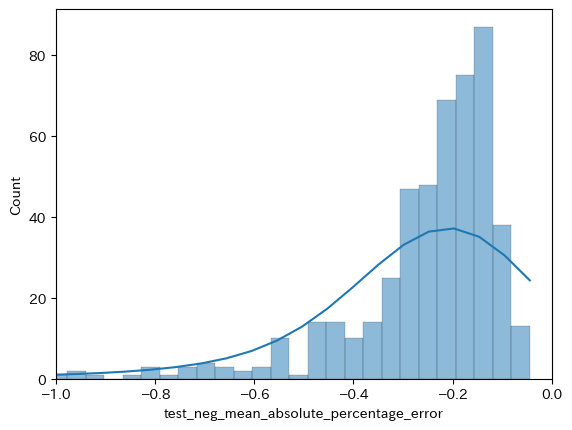

In [4]:
h = sns.histplot(data=scores, x='test_neg_mean_absolute_percentage_error', kde=True)
h.set(xlim=(-1, 0))

In [5]:
s = pd.DataFrame({
    'coef': X.columns,
    'value': model.coef_
})
s.sort_values('value').style.format("{:}")
# s[~s['coef'].str.contains('area|nearest')].sort_values('value').style.format("{:}")
# s[s['coef'].str.contains('nearest')].sort_values('value').style.format("{:}")
# s[s['coef'].str.contains('date')].sort_values('value').style.format("{:}")
s[s['coef'].str.contains('building_type')].sort_values('value').style.format("{:}")


,coef,value
81,"C(building_type, contr.treatment('NA'))[ＲＣ]:age:house_m2",-11260.524008522118
80,"C(building_type, contr.treatment('NA'))[鉄骨造]:age:house_m2",-10465.931250418409
79,"C(building_type, contr.treatment('NA'))[軽量鉄骨造]:age:house_m2",-10134.050878357553
78,"C(building_type, contr.treatment('NA'))[木造]:age:house_m2",-8401.304684344028
82,"C(building_type, contr.treatment('NA'))[ＳＲＣ]:age:house_m2",-4015.295944845988
8,"C(building_type, contr.treatment('NA'))[ＳＲＣ]:house_m2",-2464.542702645144
3,"C(building_type, contr.treatment('NA'))[NA]:house_m2",0.0
77,"C(building_type, contr.treatment('NA'))[NA]:age:house_m2",0.0
4,"C(building_type, contr.treatment('NA'))[木造]:house_m2",150968.14506184726
5,"C(building_type, contr.treatment('NA'))[軽量鉄骨造]:house_m2",194796.56603350618


In [8]:
x = {
    'is_new': 0,
    'is_house': 1,
    'price': 72800000,
    'orientation': '南',
    'house_m2': 96,
    'land_m2': 88,
    'building_type': '軽量鉄骨造',
    'age': 2025-2015,
    'area_name': '王子',
    'nearest_station_name': '王子',
    'nearest_station_minutes': 12,
    'building_ratio': 60.0,
    'floor_ratio': 150.0,
    'area': '滝野川',
    'area_plan': '１中住専',
    'land_shape': 'ほぼ長方形',
    'next': '住宅',
    'date': int(2025) - 2020,
    'road': 10
}
yy = x['price']
x = pt.model_spec.get_model_matrix(x)
x

,is_house,is_new:house_m2,date:house_m2,"C(building_type, contr.treatment('NA'))[NA]:house_m2","C(building_type, contr.treatment('NA'))[木造]:house_m2","C(building_type, contr.treatment('NA'))[軽量鉄骨造]:house_m2","C(building_type, contr.treatment('NA'))[鉄骨造]:house_m2","C(building_type, contr.treatment('NA'))[ＲＣ]:house_m2","C(building_type, contr.treatment('NA'))[ＳＲＣ]:house_m2",date:land_m2,...,"C(land_shape, contr.treatment('正方形'))[T.不整形]:land_m2","C(land_shape, contr.treatment('正方形'))[T.台形]:land_m2","C(land_shape, contr.treatment('正方形'))[T.袋地等]:land_m2","C(land_shape, contr.treatment('正方形'))[T.長方形]:land_m2","C(building_type, contr.treatment('NA'))[NA]:age:house_m2","C(building_type, contr.treatment('NA'))[木造]:age:house_m2","C(building_type, contr.treatment('NA'))[軽量鉄骨造]:age:house_m2","C(building_type, contr.treatment('NA'))[鉄骨造]:age:house_m2","C(building_type, contr.treatment('NA'))[ＲＣ]:age:house_m2","C(building_type, contr.treatment('NA'))[ＳＲＣ]:age:house_m2"
0,1,0,480,0,0,96,0,0,0,440,...,0,0,0,0,0,0,960,0,0,0


(0.0, 200000000.0)

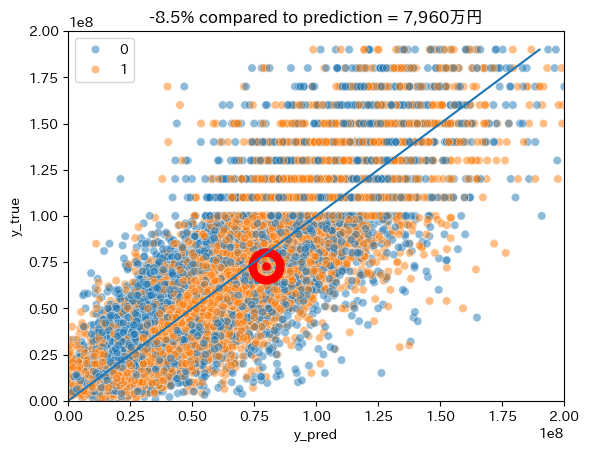

In [9]:
import matplotlib.pyplot as plt

data = pd.DataFrame({
    'y_pred': model.predict(X),
    'y_true': y,
    'is_house': X.is_house
})
sns.scatterplot(data, x='y_pred', y='y_true', hue='is_house', alpha=0.5)
sns.lineplot(data, x='y_true', y='y_true')

yp = model.predict(x)[0]
plt.scatter(yp, yy, c='r', linewidths=20)

plt.title(f'{yy / yp - 1:.1%} compared to prediction = {yp / 10000:,.0f}万円')
plt.xlim(0, 2e8)
plt.ylim(0, 2e8)

In [ ]:
import joblib

joblib.dump(pt, 'proptrans.pkl')
joblib.dump(model, 'model.pkl')
s.to_csv('coef_.csv', index=False)